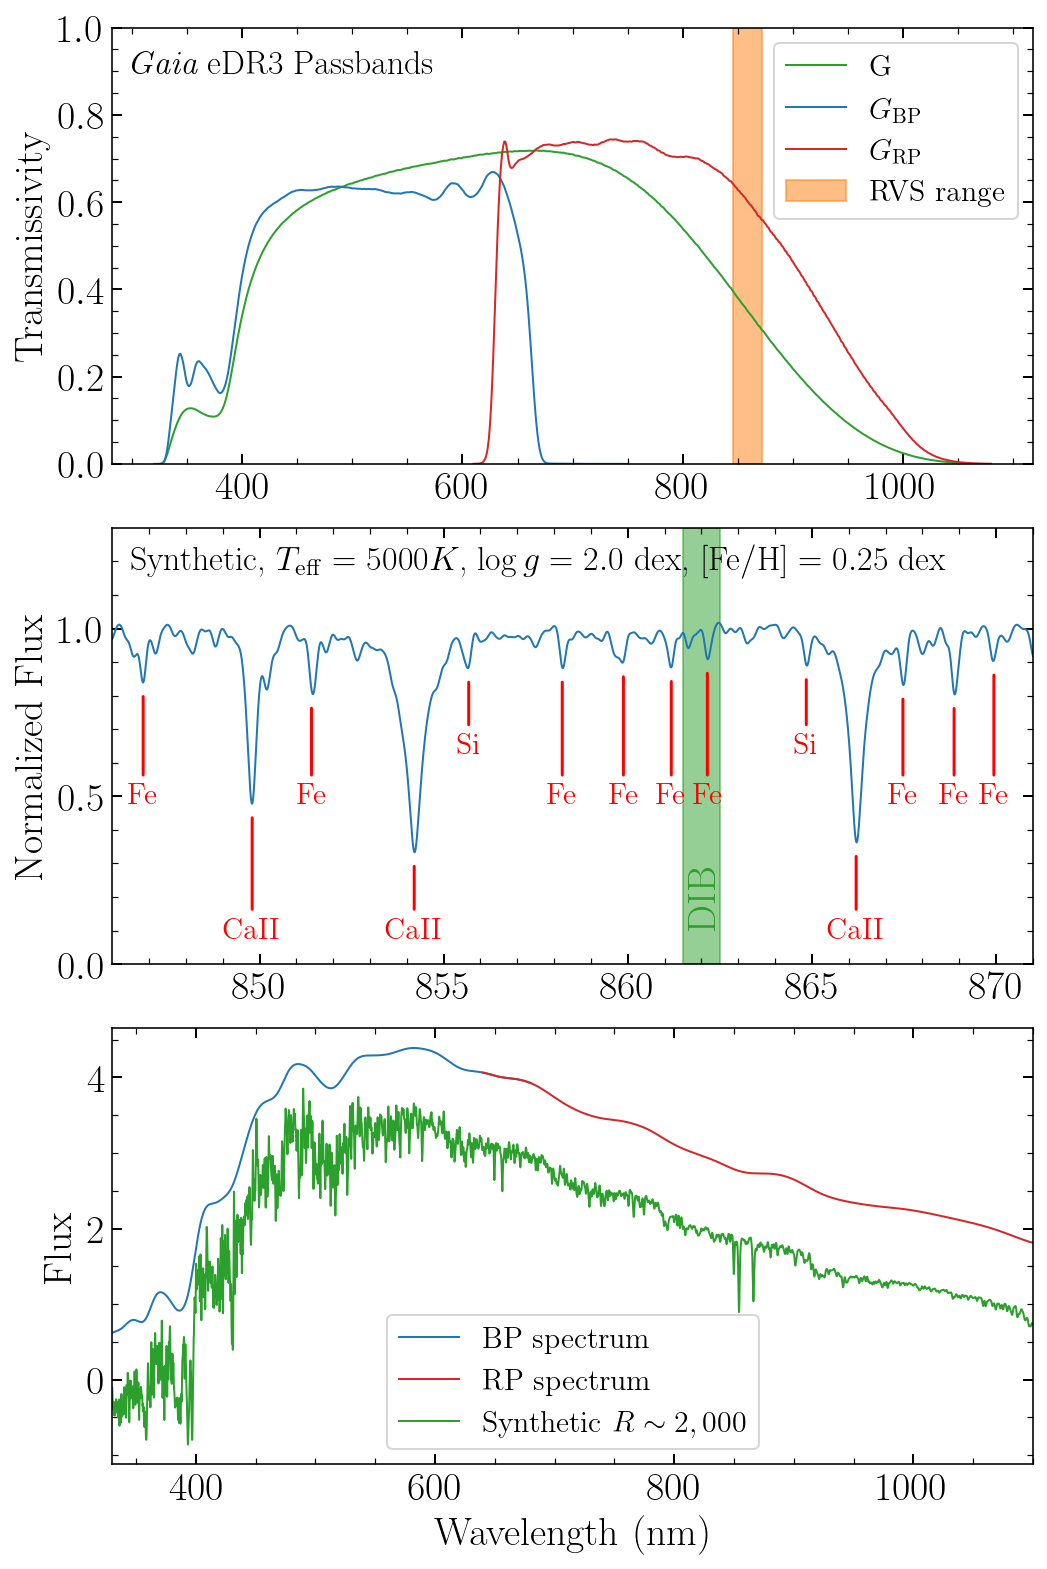

In [45]:
import numpy as np
import pylab as plt
from astroNN.shared.matplotlib import pylab_style
from astropy.convolution import convolve, Gaussian1DKernel, convolve_fft
from scipy.stats import binned_statistic

pylab_style(paper=True)

passbands = np.genfromtxt("GaiaEDR3_passbands_zeropoints_version2/passband.dat")

def spec_downR(wav, spec, R = 11500, w_sample=1):
    # Generate logarithmic wavelength grid for smoothing
    w_logmin = np.log10(np.nanmin(wav))
    w_logmax = np.log10(np.nanmax(wav))
    n_w = np.size(wav)*w_sample
    w_log = np.logspace(w_logmin, w_logmax, num=n_w)

    # Find stddev of Gaussian kernel required for smoothing resolution down to R
    R_grid = (w_log[1:-1]+w_log[0:-2])/(w_log[1:-1]-w_log[0:-2])/2
    sigma = np.max([1., np.median(R_grid)/R])  # sigma cannot be subpixel wide
    f_log = np.interp(w_log, wav, con_spec)
    gauss = Gaussian1DKernel(stddev=sigma)
    f_conv = convolve_fft(f_log, gauss)
    _con_spec = np.interp(wav, w_log, f_conv)
    return _con_spec

wavelength = passbands[:, 0]
G = passbands[:, 1]
BP = passbands[:, 3]
RP = passbands[:, 5]

G[G==99.99] = np.nan
BP[BP==99.99] = np.nan
RP[RP==99.99] = np.nan

f = np.genfromtxt("M_s5000g2.0z0.25t1.0_a0.00c0.00n0.00o0.00r0.00s0.00_VIS.spec.flat/M_s5000g2.0z0.25t1.0_a0.00c0.00n0.00o0.00r0.00s0.00_VIS.spec")
wav = f[:, 0]/10
con_spec = f[:, 1][(wav > 845) & ((wav < 873))]
wav = wav[(wav > 845) & ((wav < 873))]
# corr = ((con_spec[-250] - con_spec[100]) / (wav[-250] - wav[100]))
# con_spec = con_spec / (corr * (wav-847) + 1)
con_spec = con_spec / np.percentile(con_spec, 90)

con_spec = spec_downR(wav, con_spec, R=11500, w_sample=1)
con_spec = con_spec[(wav > 846) & ((wav < 872))]
wav = wav[(wav > 846) & ((wav < 872))]
corr = ((con_spec[-250] - con_spec[100]) / (wav[-250] - wav[100]))
con_spec = con_spec / (corr * (wav-846) + 1)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7.5, 11.))
ax1.plot(wavelength, G, c="C2", label="G")
ax1.plot(wavelength, BP, c="C0", label="$G_{\mathrm{BP}}$")
ax1.plot(wavelength, RP, c="C3", label="$G_{\mathrm{RP}}$")
ax1.axvspan(846, 872, alpha=0.5, color='C1', label="RVS range")
ax1.set_ylim(0, 1)
ax1.legend(loc="best")
ax1.set_ylabel("Transmissivity")
ax1.text(
    300,
    0.95,
    r"$\emph{Gaia}$ eDR3 Passbands",
    fontsize=17,
    ha="left",
    va="top",
)

ax2.plot(wav, con_spec)
ax2.set_xlim(846, 871)
ax2.set_ylim(0.0, 1.3)
# ax2.set_xlabel("Wavelength (nm)")
ax2.set_ylabel("Normalized Flux")
ax2.text(
    846.5,
    1.25,
    r"Synthetic, $T_\mathrm{eff}=5000K$, $\log g = 2.0\ \mathrm{dex}$, $[\mathrm{Fe/H}] = 0.25\ \mathrm{dex}$",
    fontsize=17,
    ha="left",
    va="top",
)

for i in [849.8,  854.2, 866.2]:
    top_loc = np.min(con_spec[(wav>i-0.1) & (wav<i+0.1)])
    ax2.annotate(
    "CaII",
    xy=(i, top_loc-0.03),
    xytext=(i, 0.1),
    color="red",
    fontsize=15,
    va="center",
    ha="center",
    arrowprops=dict(arrowstyle="-", color="red", linewidth=1.5)
    )

for i in [846.84, 851.41, 858.22, 859.88, 861.18, 862.16, 867.47, 868.86, 869.94]:
    top_loc = np.min(con_spec[(wav>i-0.1) & (wav<i+0.1)])
    ax2.annotate(
    "Fe",
    xy=(i, top_loc-0.03),
    xytext=(i, 0.5),
    color="red",
    fontsize=15,
    va="center",
    ha="center",
    arrowprops=dict(arrowstyle="-", color="red", linewidth=1.5)
    )
    
for i in [855.68, 864.846]:
    top_loc = np.min(con_spec[(wav>i-0.1) & (wav<i+0.1)])
    ax2.annotate(
    "Si",
    xy=(i, top_loc-0.03),
    xytext=(i, 0.65),
    color="red",
    fontsize=15,
    va="center",
    ha="center",
    arrowprops=dict(arrowstyle="-", color="red", linewidth=1.5)
    )
    
ax2.axvspan(861.5, 862.5, alpha=0.5, color='C2', label="DIB")
ax2.annotate(
"DIB",
xy=(862.1, 0.2),
xytext=(862.1, 0.2),
color="C2",
fontsize=20,
va="center",
ha="center", 
rotation=90
)

wav = f[:, 0]/10
con_spec = f[:, 1][(wav > 200) & ((wav < 800))]
wav = wav[(wav > 200) & ((wav < 800))]
con_spec = spec_downR(wav, con_spec, R=70, w_sample=1)
con_spec = con_spec[(wav > 330) & ((wav < 680))]
wav = wav[(wav > 330) & ((wav < 680))]
mean, xe, binnum = binned_statistic(wav, con_spec, statistic=np.nanmean, range=(329.5, 680.5), bins=(680.5-329.5))
ax3.plot((xe[:-1] + xe[1:]) / 2, mean / 10**6, c="C0", label="BP spectrum")
# ax3.plot((xe[:-1] + xe[1:]) / 2, mean / 10**6 * BP[(wavelength>=330) & (wavelength<=680)], c="C0", label="BP spectrum")

wav = f[:, 0]/10
con_spec = f[:, 1][(wav > 500) & ((wav < 1200))]
wav = wav[(wav > 500) & ((wav < 1200))]
con_spec = spec_downR(wav, con_spec, R=70, w_sample=1)
con_spec = con_spec[(wav > 640) & ((wav < 1100))]
wav = wav[(wav > 640) & ((wav < 1100))]

mean, xe, binnum = binned_statistic(wav, con_spec, statistic=np.nanmean, range=(639.5, 1100.5), bins=(1100.5-639.5))
ax3.plot((xe[:-1] + xe[1:]) / 2, mean / 10**6, c="C3", label="RP spectrum")
# ax3.plot((xe[:-1] + xe[1:]) / 2, mean / 10**6 * RP[(wavelength>=640) & (wavelength<=1100)], c="C1", label="RP spectrum")

wav = f[:, 0]/10
con_spec = f[:, 1][(wav > 200) & ((wav < 1200))]
wav = wav[(wav > 200) & ((wav < 1200))]
con_spec = spec_downR(wav, con_spec, R=2000, w_sample=1)
con_spec = con_spec[(wav > 330) & ((wav < 1100))]
wav = wav[(wav > 330) & ((wav < 1100))]
ax3.plot(wav, con_spec / 10**6 - 1, c="C2", label=r"Synthetic $R \sim 2,000$")

ax3.set_xlim(330, 1100)
# ax2.set_ylim(0.0, 1.3)
ax3.set_xlabel("Wavelength (nm)")
ax3.set_ylabel("Flux")
ax3.legend(loc="best")
fig.tight_layout()
fig.savefig("gaia_photon.pdf")